In [3]:
# data pre processing
crimes <- read.csv("../data/crimes.csv")
crimes$region_central <- crimes$region == "central"
crimes$region_west <- crimes$region == "west"
# crimes$region_other <- crimes$region == "other"

crimes$region_central <- as.integer(as.logical(crimes$region_central))
crimes$region_west <- as.integer(as.logical(crimes$region_west))
# crimes$region_other <- as.integer(as.logical(crimes$region_other))

crimes <- subset(crimes, select = -c(region, name))
crimes$crimes <- round(log(crimes$crimes))

In [4]:
# functions for the design matrix
# install.packages("dplyr")
require(dplyr)

rnd_design_matrix <- function(original_data, num_rows) {
    des_mx <- data.frame(original_data) # copy the data frame
    des_mx <- des_mx[0,] # delete all rows
    
    for (i in 1 : num_rows) {
        # Add the row
        des_mx <- rbind(des_mx, sample_n(original_data, 1))
    }
    
    return(des_mx)
}

add_to_design_matrix <- function(curr_design_matrix, original_data, num_rows){
    des_mx <- data.frame(curr_design_matrix) # copy the data frame
    
    for (i in 1 : num_rows) {
        # Add the row
        des_mx <- rbind(des_mx, sample_n(original_data, 1))
    }
    
    return(des_mx)
}

Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [5]:
# calculates the confidence intervalls for a model
likelihood_confidence <- function(model, alpha){
    df <- as.data.frame(matrix(ncol = 2))
    colnames(df) <- c("2.5%", "97.5%")
    df <- df[0,]
    
    bound = 1 - alpha/2
    
    row_names <- c()
    
    for (i in 1:length(coef(model))){
        l_bound = coef(model)[i] - qnorm(bound) * sqrt(vcov(model)[i,i])
        u_bound = coef(model)[i] + qnorm(bound) * sqrt(vcov(model)[i,i])
        
        name = names(coef(model)[i])
        row_names <- append(row_names, name)
        
        df[nrow(df) + 1,] = c(l_bound,u_bound)
    }
    rownames(df) <- row_names
    return(df)
}

In [6]:
# get confidence intervalls for pseudo observations
get_intervals <- function(design_matrix, mu){
    # simulate pseudo observations
    n = nrow(design_matrix)
    y.sim = rpois(n, mu)
    
    # learn model
    m = glm(y.sim ~ I(prbpris^2)+ I(sqrt(density))+ I(sqrt(wser)) + wtrd+ I(wtrd^2) + area + polpc:area + area:density, data=design_matrix, family=poisson(link="log"))
    
    # Calculate confidence intervalls
    my_conf = likelihood_confidence(m, 0.05)
    r_conf = suppressMessages(confint(m))
    
    return(list(my_conf, r_conf))
}

# get m confidence intervalls for m different pseudo observations
get_m_intervals <- function(m, design_matrix, mu){
    intervals = get_intervals(design_matrix, mu)
    my_conf = intervals[[1]]
    r_conf = intervals[[2]]
    
    my_m_intervals = data.frame(my_conf)   
    r_m_intervals = data.frame(r_conf)
    
    for (i in 1:(m-1)){
        intervals = get_intervals(design_matrix, mu)
        my_conf = intervals[[1]]
        r_conf = intervals[[2]]
        
        my_m_intervals = cbind(my_m_intervals, my_conf)
        r_m_intervals = cbind(r_m_intervals, r_conf)
    }
    
    return(list(my_m_intervals, r_m_intervals))
}

# evaluates the m intervals in comparison to the true coefficients
eval_m_intervals <- function(true_coef, my_m_intervals, r_m_intervals){
    num_coef = nrow(true_coef)
    m = ncol(my_m_intervals)/2
    
    r_conf_hits = my_conf_hits = rep(0, length.out=num_coef)
    
    for (j in 1:m){
        l_bound = my_m_intervals[ , j*2 - 1]
        u_bound = my_m_intervals[ , j*2]       
        for (i in 1:num_coef){
            coe = true_coef[i,1]           
            if (coe > l_bound[i] && coe < u_bound[i]){
                #print(c(l_bound[i],coe,u_bound[i]))
                my_conf_hits[i] = my_conf_hits[i] + 1
            }
        }
        
        l_bound = r_m_intervals[ , j*2 - 1]
        u_bound = r_m_intervals[ , j*2]
        for (i in 1:num_coef){
            coe = true_coef[i,1]
            if (coe > l_bound[i] && coe < u_bound[i]){
                r_conf_hits[i] = r_conf_hits[i] + 1
            }
        }
    }
    
    r_conf_hits = r_conf_hits / m
    my_conf_hits = my_conf_hits / m
    
    return(list(my_conf_hits, r_conf_hits))
}

In [7]:
experiment = function(data, n_start, increase, num_times, m){   
    des_matrix = rnd_design_matrix(data, n_start) # create first design matrix
    
    # learn true model with the true design matrix
    true_model = glm(crimes ~ I(prbpris^2)+ I(sqrt(density))+ I(sqrt(wser)) + wtrd+ I(wtrd^2) + area + polpc:area + area:density, data=des_matrix, family=poisson(link="log"))
    # true_model = glm(crimes ~ I(prbpris^2)+ I(sqrt(density)), data=des_matrix, family=poisson(link="log"))
    true_mu = predict(true_model, type="response")
    true_coef = data.frame(coefficients=coef(true_model))
    
    # first iteration
    # simulate observations and compare with true values
    intervals = get_m_intervals(m, des_matrix, true_mu)
    my_conf = intervals[[1]]
    r_conf = intervals[[2]]
    
    hits = eval_m_intervals(true_coef, r_conf, my_conf)
    
    r_res = data.frame(n_start = hits[[1]])
    my_res = data.frame(n_start = hits[[2]])
    
    rownames(r_res) = names(coef(true_model))
    rownames(my_res) = names(coef(true_model))
    
    colnames(r_res) = c(n_start)
    colnames(my_res) = c(n_start)
    
    
    for (n in 1:num_times){
        des_matrix = add_to_design_matrix(des_matrix, crimes, increase)
        
        # learn true model with the true design matrix
        true_model = glm(crimes ~ I(prbpris^2)+ I(sqrt(density))+ I(sqrt(wser)) + wtrd+ I(wtrd^2) + area + polpc:area + area:density, data=des_matrix, family=poisson(link="log"))
        true_mu = predict(true_model, type="response")
        true_coef = data.frame(coefficients=coef(true_model))
        
        # simulate observations and compare with true values
        intervals = get_m_intervals(m, des_matrix, true_mu)
        my_conf = intervals[[1]]
        r_conf = intervals[[2]]
        hits = eval_m_intervals(true_coef, r_conf, my_conf)
        
        temp_r_res = data.frame(x = hits[[1]])
        temp_my_res = data.frame(x = hits[[2]])
        
        colnames(temp_r_res) = c(nrow(des_matrix))
        colnames(temp_my_res) = c(nrow(des_matrix))
                
        r_res = cbind(r_res, temp_r_res)
        my_res = cbind(my_res, temp_my_res)
        cat(n)
        cat(' ')
        print(Sys.time())
    }
    
    return(list(r_res, my_res))
}

In [8]:
library(parallel)

mc_part = function(des_matrix, m) {
    # learn true model with the true design matrix
    true_model = glm(crimes ~ I(prbpris^2)+ I(sqrt(density))+ I(sqrt(wser)) + wtrd+ I(wtrd^2) + area + polpc:area + area:density, data=des_matrix, family=poisson(link="log"))
    true_mu = predict(true_model, type="response")
    true_coef = data.frame(coefficients=coef(true_model))
        
        # simulate observations and compare with true values
    intervals = get_m_intervals(m, des_matrix, true_mu)
    my_conf = intervals[[1]]
    r_conf = intervals[[2]]
    hits = eval_m_intervals(true_coef, r_conf, my_conf)
        
    temp_r_res = data.frame(x = hits[[1]])
    temp_my_res = data.frame(x = hits[[2]])
        
    colnames(temp_r_res) = c(nrow(des_matrix))
    colnames(temp_my_res) = c(nrow(des_matrix))
                
    print(Sys.time())
    print(dim(des_matrix))
    return(list(temp_r_res, temp_my_res))
}

mc_experiment = function(data, n_start, increase, num_times, m){   
    des_matrix = rnd_design_matrix(data, n_start) # create first design matrix
    
    # learn true model with the true design matrix
    true_model = glm(crimes ~ I(prbpris^2)+ I(sqrt(density))+ I(sqrt(wser)) + wtrd+ I(wtrd^2) + area + polpc:area + area:density, data=des_matrix, family=poisson(link="log"))
    # true_model = glm(crimes ~ I(prbpris^2)+ I(sqrt(density)), data=des_matrix, family=poisson(link="log"))
    true_mu = predict(true_model, type="response")
    true_coef = data.frame(coefficients=coef(true_model))
    
    # first iteration
    # simulate observations and compare with true values
    intervals = get_m_intervals(m, des_matrix, true_mu)
    my_conf = intervals[[1]]
    r_conf = intervals[[2]]
    
    hits = eval_m_intervals(true_coef, r_conf, my_conf)
    
    r_res = data.frame(n_start = hits[[1]])
    my_res = data.frame(n_start = hits[[2]])
    
    rownames(r_res) = names(coef(true_model))
    rownames(my_res) = names(coef(true_model))
    
    colnames(r_res) = c(n_start)
    colnames(my_res) = c(n_start)
    
    des_matrices = list(des_matrix)
    for (n in 2:num_times){
        des_matrices[[n]] = add_to_design_matrix(des_matrices[[n-1]], crimes, increase)
        print(n)
    }
    results = mclapply(des_matrices, function(des_m) {mc_part(des_m, m)}, mc.cores = 8)
    return(results)
}

In [19]:
a = list(1)
a[[2]] = 1
a[[2]]

[1] 1

In [9]:
res = mc_experiment(crimes, 30, 5000, 20, 300) # 5000, 20, 150)

[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20


ERROR: Error in mclapply(des_matrices, function(des_m) {: 'mc.cores' > 1 is not supported on Windows


In [12]:
res

30
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9
1.0
30


1 [1] "2021-09-29 12:48:36 CEST"
2 [1] "2021-09-29 12:52:53 CEST"
3 [1] "2021-09-29 12:58:10 CEST"
4 [1] "2021-09-29 13:04:32 CEST"
5 [1] "2021-09-29 13:12:32 CEST"
6 [1] "2021-09-29 13:21:59 CEST"
7 [1] "2021-09-29 13:32:40 CEST"
8 [1] "2021-09-29 13:44:47 CEST"
9 [1] "2021-09-29 13:59:51 CEST"
10 [1] "2021-09-29 14:16:13 CEST"
11 [1] "2021-09-29 14:32:32 CEST"
12 [1] "2021-09-29 14:50:38 CEST"
13 [1] "2021-09-29 15:12:09 CEST"
14 [1] "2021-09-29 15:33:57 CEST"
15 [1] "2021-09-29 15:57:13 CEST"
16 [1] "2021-09-29 16:21:53 CEST"
17 [1] "2021-09-29 16:49:09 CEST"
18 [1] "2021-09-29 17:17:10 CEST"
19 [1] "2021-09-29 17:49:15 CEST"
20 [1] "2021-09-29 18:21:23 CEST"


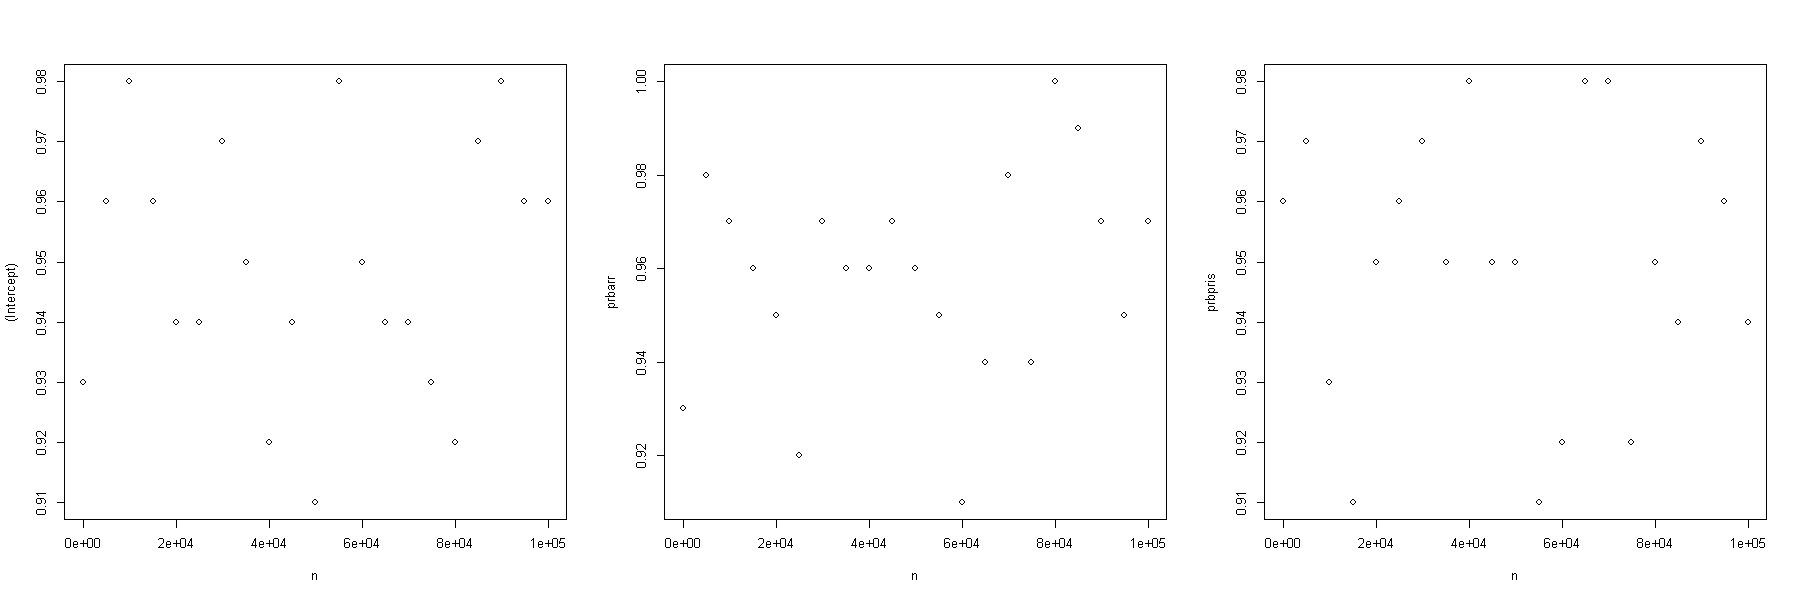

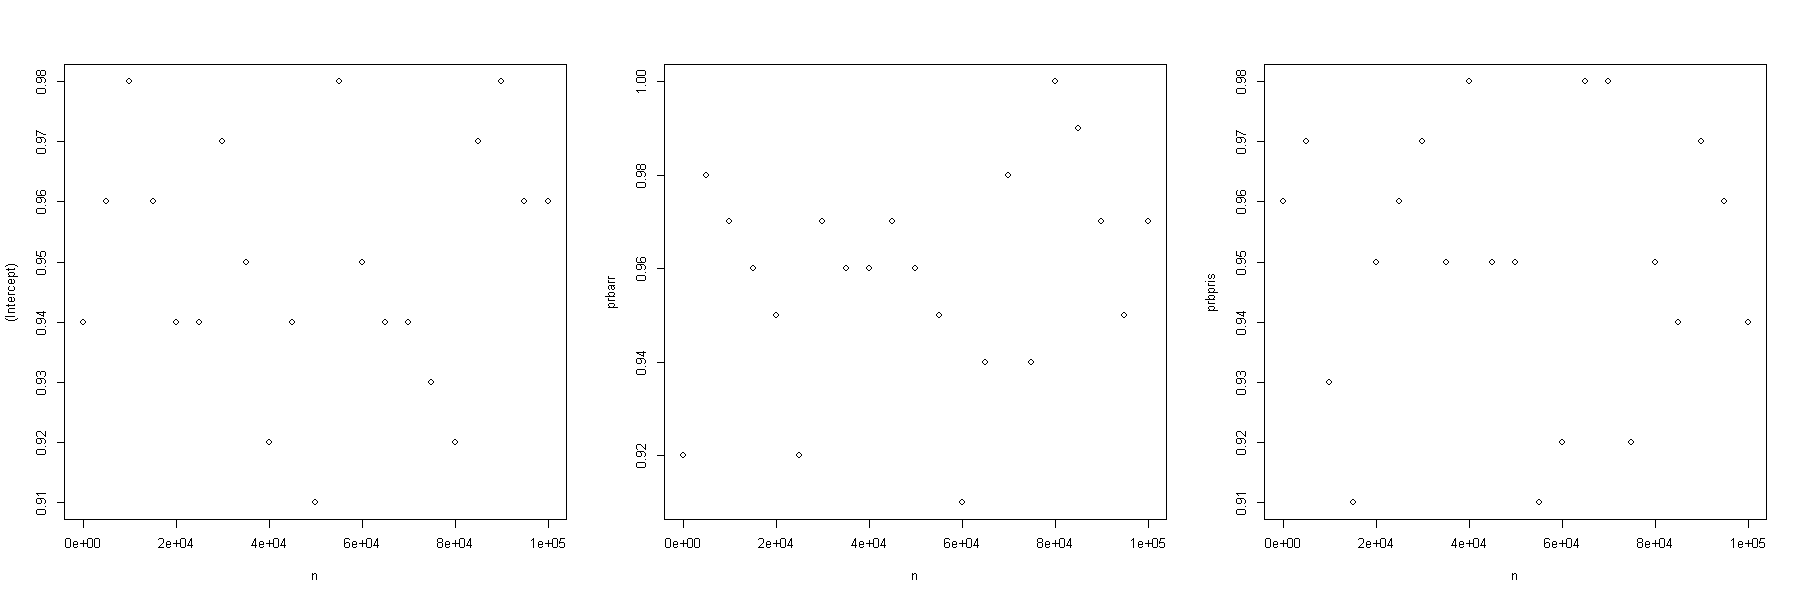

In [49]:
res = experiment(crimes, 30, 5000, 20, 150)
r_res = res[[1]]
my_res = res[[2]]

r_res = rbind(as.numeric(colnames(r_res)), r_res)
my_res = rbind(as.numeric(colnames(my_res)), my_res)

r_res = t(r_res)
my_res = t(my_res)

write.csv(r_res, file = "r_res.csv")
write.csv(my_res, file = "my_res.csv")

options(repr.plot.width = 15, repr.plot.height = 5)
par(mfrow=c(1,3))

plot(r_res[, 1], r_res[, 2], xlab="n", ylab="(Intercept)")
plot(r_res[, 1], r_res[, 3], xlab="n", ylab="prbarr")
plot(r_res[, 1], r_res[, 4], xlab="n", ylab="prbpris")

plot(my_res[, 1], my_res[, 2], xlab="n", ylab="(Intercept)")
plot(my_res[, 1], my_res[, 3], xlab="n", ylab="prbarr")
plot(my_res[, 1], my_res[, 4], xlab="n", ylab="prbpris")

In [50]:
(colMeans = colMeans(r_res))
colMeans = sapply(2:length(colMeans), function(i) colMeans[i])
mean(colMeans)

(colMeans = colMeans(my_res))
colMeans = sapply(2:length(colMeans), function(i) colMeans[i])
mean(colMeans)

1      (Intercept)     I(prbpris^2) I(sqrt(density)) 
    5.003000e+04     9.490476e-01     9.585714e-01     9.500000e-01 
   I(sqrt(wser))             wtrd        I(wtrd^2)             area 
    9.433333e-01     9.461905e-01     9.438095e-01     9.538095e-01 
      area:polpc     area:density 
    9.538095e-01     9.495238e-01

[1] 0.9497884

1      (Intercept)     I(prbpris^2) I(sqrt(density)) 
    5.003000e+04     9.495238e-01     9.580952e-01     9.500000e-01 
   I(sqrt(wser))             wtrd        I(wtrd^2)             area 
    9.433333e-01     9.461905e-01     9.438095e-01     9.538095e-01 
      area:polpc     area:density 
    9.538095e-01     9.495238e-01

[1] 0.9497884